- **Module:** read_and_map_aeronet.ipynb
- **Authors:** Petar Grigorov, Alqamah Sayeed, and Pawan Gupta
- **Organization:** NASA AERONET (https://aeronet.gsfc.nasa.gov/)
- **Date:** 06/18/2023
- **Last Revision:** 07/29/2024
- **Purpose:** To access and map the AERONET data from Web API
- **Disclaimer:** The code is for demonstration purposes only. Users are responsible to check for accuracy and revise to fit their objective.
- **Contact:** Report any concern or question related to the code to pawan.gupta@nasa.gov or petar.t.grigorov@nasa.gov
- **Readme:** https://github.com/pawanpgupta/AERONET/blob/Python/README/Read_and_map_AERONET

**Required packages installation and importing**

In [1]:
!pip uninstall -y numpy pandas shapely
!pip install numpy==1.26.4 pandas==2.0.3 shapely==1.8.5
!pip install cartopy
!pip install beautifulsoup4
!pip install requests
!pip install geopandas

from bs4 import BeautifulSoup      #reads data from website (web scraping)
import re                          #regular expression matching operations (RegEx)
import requests                    #useful for sending HTTP requests using python
import shutil                      #useful for creating zip files
import numpy as np                 #for array manipulation
import datetime                    #for time data manipulation
import pandas as pd                #for data querying and processing
import geopandas as gpd            #same as pandas, but for geospatial data
import matplotlib.pyplot as plt    #for creating plots

import cartopy.crs as ccrs         #for creating geographical maps
import cartopy.feature as cfeature
from copy import deepcopy as dc

import warnings
warnings.filterwarnings('ignore')

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: shapely 2.0.6
Uninstalling shapely-2.0.6:
  Successfully uninstalled shapely-2.0.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
geopandas 1.0.1 requires shapely>=2.0.0, but you have shapely 1.8.5 which is incompatible.
google-co

**Connecting and mounting local drive onto colab notebook**

In [2]:
from google.colab import files      #ensures output zip file can be downloaded
from google.colab import drive      #imports local google drive
drive.mount('/drive')               #mounts local google drive onto colab
!mkdir Output                       #makes directory where output files will be stored

Mounted at /drive


**Setup input parameters such as date, data level, averaging type, AOD range for mapping, AOD/Angstrom exponent, and geographical limits**

In [3]:
dt_initial = '20240626'                 #starting date YYYYMMDD format
dt_final = '20240702'                   #final date YYYYMMDD format
level = 1.5                             #AERONET data level
average_type = 3                        #daily (1), hourly (2), timeavg (3)
vis_min = 0.0                           #any AOD/AE with smaller value will show as green on the color map, adjust as necessary
vis_max = 1.0                           #any AOD/AE with larger value will show as red on the color map, adjust as necessary
feature_choice = 1                      #Enter '1' if you are specifying an AOD wavelength or '2' if you are specifying an Angstrom exponent
wavelength = 500                        #Available choices: 1640, 1020, 870, 865, 779, 675, 667, 620, 560, 555, 551, 532, 531, 510, 500, 490, 443, 440, 412, 400, 380, 340
Angstrom_exp = '440-675'                #Available choices: '440-870','380-500','440-675','500-870','340-440','440-675(Polar)'
#Bounding box: Coordinates must be in decimal degrees (including decimal)
lat1,lon1 = 23.,-135.                   #lat1,lon1 - Lower Left
lat2,lon2 = 53.,-65.                    #lat2,lon2 - Upper Right

**Get desired AERONET data using web services, then scraping data from website**

In [4]:
yr_initial = dt_initial[:4]               #initial year
mon_initial = dt_initial[4:6]             #initial month
day_initial = dt_initial[6:]              #initial day

yr_final = dt_final[:4]                   #final year
mon_final = dt_final[4:6]                 #final month
day_final = dt_final[6:]                  #final day

if level == 1 or level == 1.0:
  level = 10
elif level == 1.5:
  level = 15
elif level == 2 or level == 2.0:
  level = 20
else:
  print("\nIncorrect input for data level type. Defaulting to level 1.5...")
  level = 15

if vis_min < 0 or vis_max <= 0:
  vis_min = 0
  vis_max = 1
  print("\nIncorrect entry. Numbers cannot be negative. Defaulting to [0,1] range...")
elif vis_min >= vis_max:         #if someone accidentally switches the colorbar limits, where the max is he smaller number, the values are swapped.
  vis_min = 0
  vis_max = 1
  print("\nColorbar limit input does not match format. Lower bound cannot be greater than the upper. Defaulting to [0,1] range..")

if level == 20 and int(yr_initial) == datetime.date.today().year:                 #if user wants level 2 data for the current year, program alerts that data may not be available
  level = 15                                                                      #defaults to level 1.5 data
  print("\nThere is no level 2 data available for the current year. Defaulting to level 1.5 data...")

url = 'https://aeronet.gsfc.nasa.gov/cgi-bin/print_web_data_v3?lat1='+str(lat1)+'&lon1='+str(lon1)+'&lat2='+str(lat2)+'&lon2='+str(lon2)+'&year='+yr_initial+'&month='+mon_initial+'&day='+day_initial+'&year2='+yr_final+'&month2='+mon_final+'&day2='+day_final+'&AOD'+str(level)+'=1&AVG=10'
soup = BeautifulSoup(requests.get(url).text) #web services contents are read here from URL

**Read and filter downloaded data as per user average type specification**

In [5]:
with open(r'/content/temp.txt' ,"w") as oFile:          #writes the data scraped from "beautiful soup" to a text file on your local Google drive
    oFile.write(str(soup.text))
    oFile.close()

df = pd.read_csv(r'/content/temp.txt',skiprows = 5)     #loads the csv data into a Pandas dataframe
!rm temp.txt

if len(df) > 0:
  df = df.replace(-999.0, np.nan)                                     #replaces all -999.0 vakyes with NaN; helps with accurate data aggregation
  df.rename(columns={'Site_Latitude(Degrees)': 'Site_Latitude', 'Site_Longitude(Degrees)': 'Site_Longitude'}, inplace = True)
  df[['Day','Month','Year']] = df['Date(dd:mm:yyyy)'].str.split(':',expand=True)                                #splits the date column and then joins it back together using "-" instead of ":"
  df['Date'] = df[['Year','Month','Day']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")       #because datetime format in python does not recognize colons
  df['Date']= pd.to_datetime(df['Date'])                              #converts the new date column to datetime format
  df['Hour'] = df['Time(hh:mm:ss)'].str[:2]                           #creates Hour column using just the HH component of the Time column
  numeric_cols = df.select_dtypes(include=['number']).columns         #defines the numeric columns, so aggregation functions do not crash with non-numeric ones.

  if average_type == 1:
    df = df.groupby(['AERONET_Site', 'Date'])[numeric_cols].mean()         #The "groupby" function is used to obtain average daily (or hourly) AOD wavelength for each AERONET site.                                                                 # np.mean() function is used to compute the arithmetic average of the array ignoring the NaN value
  elif average_type == 2:
    df = df.groupby(['AERONET_Site', 'Date','Hour'])[numeric_cols].mean()  #Groups dataset by date and hour bin
  elif average_type == 3:
    df = df.groupby(['AERONET_Site'])[numeric_cols].mean()                 #Groups dataset by the Aeronet site, and takes the total time average for each location
  else:
    average_type = 'daily'
    df = df.groupby(['AERONET_Site', 'Date']).mean()
    print("\nIncorrect input for average type. Defaulting to daily averages.")

else:
  print("No data to parse. Please retry with different parameters.")

**AOD Wavelength or Angstrom Exponent Selection**

In [6]:
AOD_col = [col for col in df.columns if 'AOD_' in col and 'nm' in col] #list of AOD columns, used for mapping user input to them
Ang_exp_col = [col for col in df.columns if 'Angstrom_Exponent' in col] #list of Angstrom Exponent columns, used for mapping user input to them

AOD_val = [int(re.search(r'\d+', col).group()) for col in AOD_col] #expected user input choices for AOD
Ang_exp_val = [item.split('_')[0] for item in Ang_exp_col] #expected user input choices for AE
Ang_exp_val[-1] += '(Polar)' #manually adds the polar channel to the list

if feature_choice == 1:
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Site_Latitude','Site_Longitude', AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")
elif feature_choice == 2:
  if Angstrom_exp in Ang_exp_val:     #if user input for Angstrom Exponent matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(Ang_exp_col)):
      if Angstrom_exp == Ang_exp_val[i]:  #code scans the list of columns and list of possible values, and matches user input to the appropriate column nam
        df = df[['Site_Latitude','Site_Longitude', Ang_exp_col[i]]]     #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','440-675']]
    print("\nInput for Angstrom Exponent is not in list. Defaulting to 440-675...")
else:
  feature_choice == 1
  print("\nIncorrect input for feature choice. Defaulting to AOD wavelength (1)...")
  if wavelength in AOD_val:             #if user input for AOD wavelength matches a value in the list, code proceeds forward. Otherwise it prompts user to try again
    for i in range(len(AOD_col)):
      if wavelength == AOD_val[i]:      #code scans the list of columns and list of possible values, and matches user input to the appropriate column name
        df = df[['Site_Latitude','Site_Longitude', AOD_col[i]]]         #if a match exists, the column name is matched to the actual column and it is then appended to the dataset
  else:
    df = df[['Site_Latitude','Site_Longitude','AOD_500nm']]
    print("\nInput for AOD wavelength is not in list. Defaulting to 500nm...")

df = df.dropna() #Drops NaN or -999.0 values
df = df.reset_index() #resets the index
df

,AERONET_Site,Site_Latitude,Site_Longitude,AOD_500nm
0,Ames,42.021361,-93.774778,0.081652
1,Appalachian_State,36.214600,-81.693800,0.083077
2,BONDVILLE,40.053333,-88.371944,0.067211
3,Billerica,42.528347,-71.268619,0.077421
4,Bozeman,45.662204,-111.045013,0.066549
...,...,...,...,...
104,WC_Whittier_CA,33.967800,-118.029900,0.098134
105,Wallops,37.932850,-75.471950,0.142509
106,White_Sands_HELSTF,32.634942,-106.338072,0.152041
107,Xavier_Univ_LA,29.964300,-90.107400,0.242200


**Map the AODs/AE using PlateCarree projection**

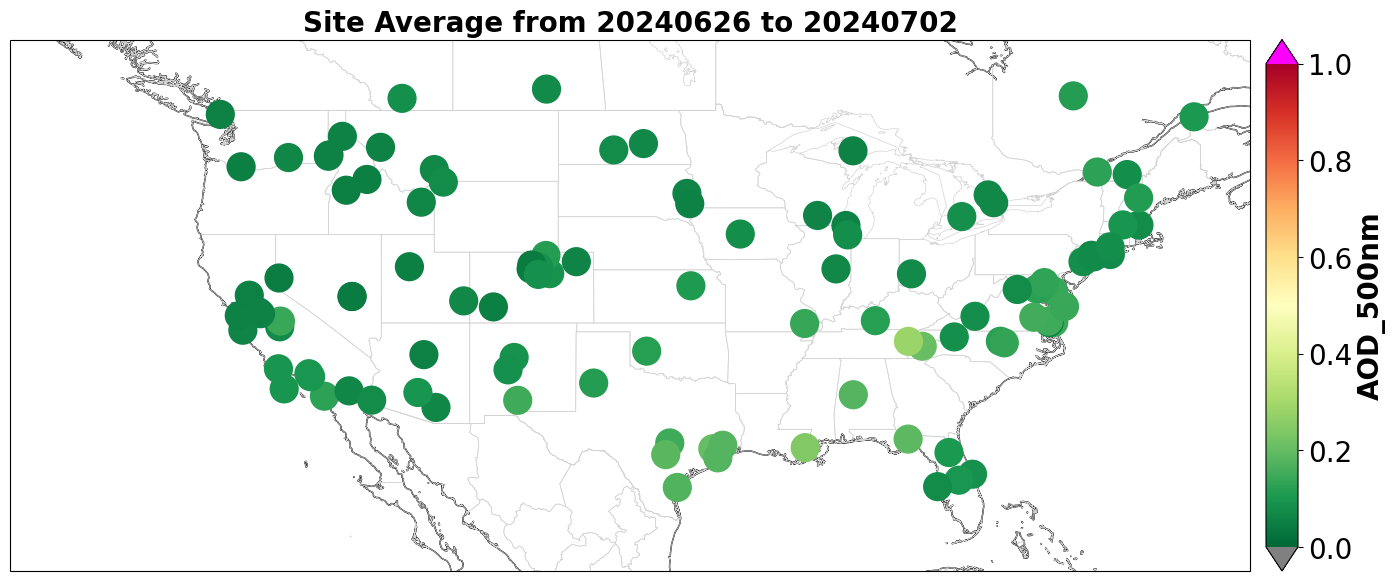

In [8]:
from copy import deepcopy
geo_df = deepcopy(df)

projection=ccrs.PlateCarree()
outdir='/content/Output/'

colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html

if average_type == 1:
  date_list = geo_df[['Date']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    plt.xlim([lon1,lon2])
    plt.ylim([lat1,lat2])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)
    ax.set_title(date_list[i],size=20, weight='bold')

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend = 'both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i])+'.png',bbox_inches='tight',dpi=400)
    plt.show()

elif average_type == 2:
  geo_df = dc(df)
  geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
  geo_df['Hour'] = geo_df['Hour'].dt.time
  geo_df['Date_Time'] = pd.to_datetime(geo_df['Date'].astype(str) + ' ' + geo_df['Hour'].astype(str))
  geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
  geo_df = geo_df.drop(columns=['Date', 'Hour'])

  date_list = geo_df[['Date_Time']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)
    geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
    geo_df['Hour'] = geo_df['Hour'].dt.time
    geo_df['Date_Time'] = pd.to_datetime(geo_df['Date'].astype(str) + ' ' + geo_df['Hour'].astype(str))
    geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
    geo_df = geo_df.drop(columns=['Date', 'Hour'])

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    plt.xlim([lon1,lon2])
    plt.ylim([lat1,lat2])

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    geo_df = geo_df.loc[geo_df['Date_Time'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400,zorder=1)

    ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

    cbar=plt.colorbar(cm, cax=cax, extend = 'both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i][:-6])+'.png', bbox_inches='tight',dpi=400)
    plt.show()

elif average_type == 3:
  geo_df = dc(df)
  fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)

  # # Comment next 2 lines if you don't want grey color map
  # countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
  # countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

  # Add coastlines
  ax.coastlines(resolution='10m',zorder=1)

  # Add state and country boundaries
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
  ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

  plt.xlim([lon1,lon2])
  plt.ylim([lat1,lat2])
  colbar = plt.cm.get_cmap('RdYlGn_r')
  colbar.set_extremes(under='gray',over='magenta')
  cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]],
                cmap=colbar, vmin = vis_min, vmax = vis_max, s = 400, zorder=2)
  ax.set_title("Site Average from "+dt_initial+" to "+dt_final,size=20, weight='bold')

  #Add colorbar
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  cbar=plt.colorbar(cm, cax=cax, extend = 'both')
  cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
  tick_font_size = 20
  cbar.ax.tick_params(labelsize=tick_font_size)

  fig.savefig(outdir+'Output_Site_Average.png',bbox_inches='tight',dpi=400)
  plt.show()

**Display map using Orthographic projection**

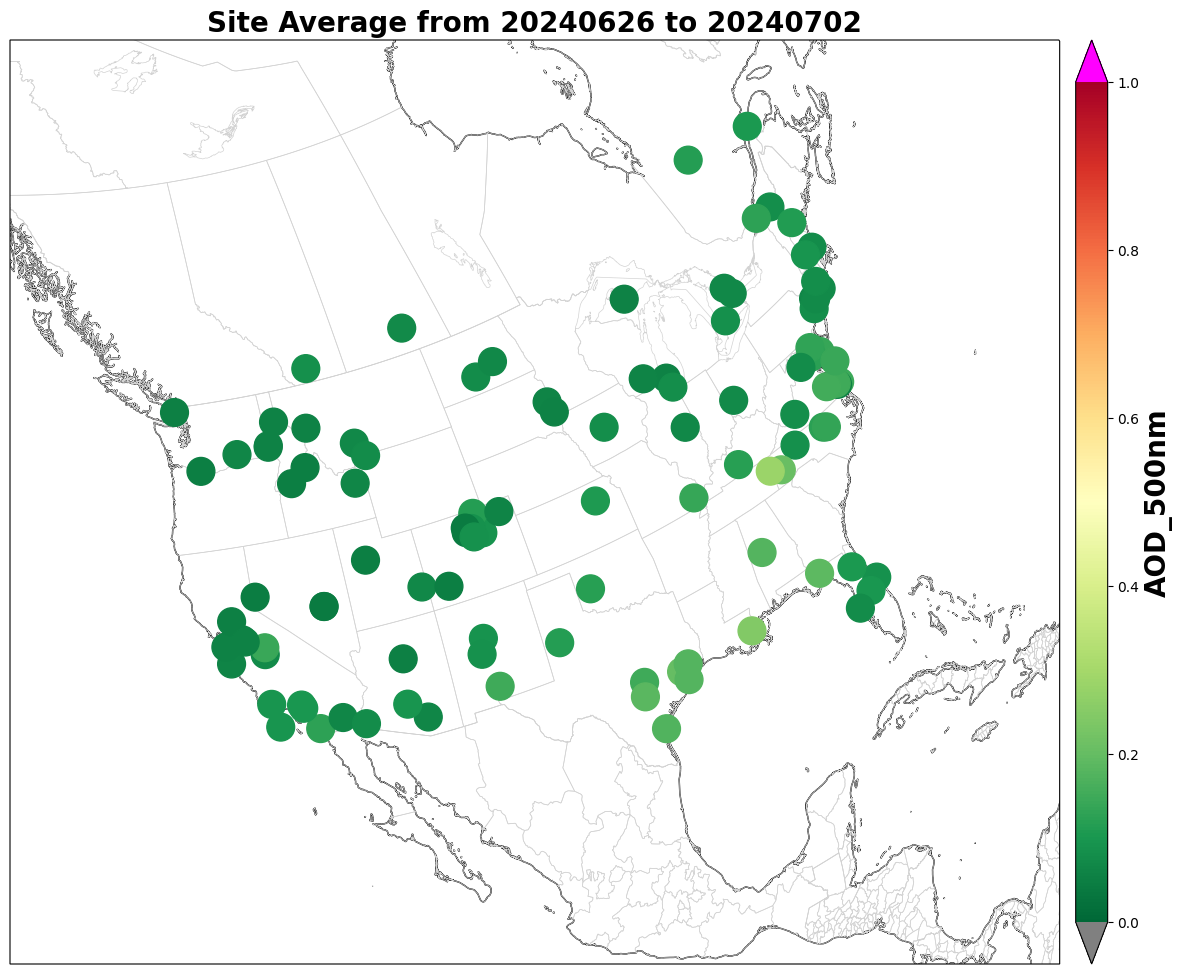

In [10]:
## Define central location for Orthogrphic projection
central_longitude = lon1 + abs (lon2 - lon2)//2
central_latitude  = lat1 + abs (lat1 - lat2)//2

### ORTHO PROJECTION CELL
projection=ccrs.Orthographic(central_longitude=central_longitude, central_latitude=central_latitude)
geo = ccrs.Geodetic()

outdir='/content/Output/'
colbar='RdYlGn_r' #https://matplotlib.org/stable/tutorials/colors/colormaps.html

if average_type == 1:

  geo_df = dc(df)
  date_list = geo_df[['Date']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

    geo_df = geo_df.loc[geo_df['Date'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                c=geo_df[geo_df.columns[-1]], cmap=colbar,
                vmin = vis_min, vmax = vis_max, s = 400, zorder=1, transform=ccrs.PlateCarree())
    ax.set_title(date_list[i],size=20, weight='bold')

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend='both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i])+'_ortho.png')
    plt.show()

elif average_type == 2:
  geo_df = dc(df)
  geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
  geo_df['Hour'] = geo_df['Hour'].dt.time
  geo_df['Date_Time'] = pd.to_datetime(geo_df['Date'].astype(str) + ' ' + geo_df['Hour'].astype(str))
  geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
  geo_df = geo_df.drop(columns=['Date', 'Hour'])

  date_list = geo_df[['Date_Time']].astype(str)
  date_list = date_list.to_numpy()
  date_list = np.unique(date_list)

  for i in range(len(date_list)):
    geo_df = dc(df)
    geo_df['Hour'] = pd.to_datetime(geo_df['Hour'].astype(str), format='%H')
    geo_df['Hour'] = geo_df['Hour'].dt.time
    geo_df['Date_Time'] = pd.to_datetime(geo_df['Date'].astype(str) + ' ' + geo_df['Hour'].astype(str))
    geo_df.insert(3, 'Date_Time', geo_df.pop('Date_Time'))
    geo_df = geo_df.drop(columns=['Date', 'Hour'])

    fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
    ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

    # Comment next 2 lines if you don't want grey color map
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1,transform=ccrs.PlateCarree())


    geo_df = geo_df.loc[geo_df['Date_Time'] == date_list[i]].reset_index(drop=True)
    colbar = plt.cm.get_cmap('RdYlGn_r')
    colbar.set_extremes(under='gray',over='magenta')
    cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                    c=geo_df[geo_df.columns[-1]], cmap=colbar, vmin = vis_min,
                    vmax = vis_max, s = 400, zorder=1, transform=ccrs.PlateCarree())
    ax.set_title(date_list[i]+str(' GMT'),size=20, weight='bold')

    # Add coastlines
    ax.coastlines(resolution='10m',zorder=0)

    # Add state and country boundaries
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=0)

    #Add colorbar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar=plt.colorbar(cm, cax=cax, extend='both')
    cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
    tick_font_size = 20
    cbar.ax.tick_params(labelsize=tick_font_size)

    fig.savefig(outdir+'Output_'+str(date_list[i][:-6])+'_ortho.png')
    plt.show()

elif average_type == 3:
  geo_df = dc(df)
  fig, ax = plt.subplots(figsize=(16,12),subplot_kw={'projection': projection},frameon=True)
  ax.set_extent([lon1,lon2,lat1,lat2],crs=ccrs.PlateCarree())

  # # Comment next 2 lines if you don't want grey color map
  # countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
  # countries.plot(color="lightgrey",ax=ax,zorder=0,alpha=0.1)

  # Add coastlines
  ax.coastlines(resolution='10m',zorder=1)

  # Add state and country boundaries
  ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)
  ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5, edgecolor='lightgray',zorder=1)

  colbar = plt.cm.get_cmap('RdYlGn_r')
  colbar.set_extremes(under='gray',over='magenta')
  cm = ax.scatter(x=geo_df["Site_Longitude"], y=geo_df["Site_Latitude"],
                  c=geo_df[geo_df.columns[-1]], cmap=colbar, vmin = vis_min, vmax = vis_max,
                  s=400, zorder=2, transform=ccrs.PlateCarree())

  ax.set_title("Site Average from "+dt_initial+" to "+dt_final, size=20, weight='bold')

  #Add colorbar
  cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
  plt.colorbar(cm, cax=cax, extend='both')
  cax.set_ylabel(geo_df.columns[-1],size=20, weight='bold')
  tick_font_size = 20
  cbar.ax.tick_params(labelsize=tick_font_size)

  fig.savefig(outdir+'Output_Site_Average_ortho.png')
  plt.show()

**Download the saved maps as png file, it will zip all the files in the folder and download**

In [11]:
while True:
  zip_download = str(input("Would you like to download your output in a zipped folder (y or n)?: "))
  if zip_download == 'y' or zip_download == 'Y' or zip_download == 'Yes' or zip_download == 'yes':
    shutil.make_archive('Output', 'zip', '/content/Output')  #zips all output files
    files.download('Output.zip')  #Note: Must use Chrome browser for download to work
    break
  elif zip_download == 'n' or zip_download == 'N' or zip_download == 'No' or zip_download == 'no':
    print("\nThanks! I hope you enjoyed the program.")
    break
  else:
    print("\nIncorrect input. Please try again!")

Would you like to download your output in a zipped folder (y or n)?: y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>